# **Event definition**

In [2]:
# TODO: expand comments to explain purpose of all packages

import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

# set range of data we want to plot
lons = slice(-85,-65); lats = slice(25,50)

# also define a smaller area that we might want to draw a box around
xn, xx, yn, yx = [-75,-70,40,45]

## **Useful methods**

In [3]:
def wrap_lon(ds):
    
    # method to 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def get_latlon(city):
    
    # retrieve lat & lon for given location
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}


## **Physical geography**

### **Elevation**
Source data: http://research.jisao.washington.edu/data_sets/elevation/

In [5]:
elev = wrap_lon(xr.open_dataset("data/elev-0.25deg.nc").squeeze(drop = True).data).sel(lon = lons, lat = lats)

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects 

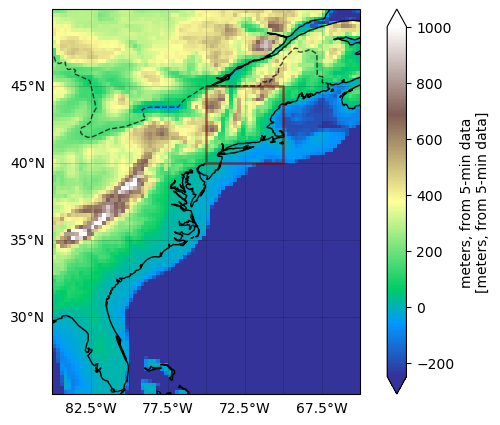

In [28]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
elev_kwargs = {"cmap" : "terrain",
               "vmin" : -250, 
               "vmax" : 1000}    # aim to keep 1:4 ratio to change from blue to green at zero
elev.plot(ax = ax, **elev_kwargs)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

# add box around area of interest
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

### **Koppen-Geiger climatology**

TODO: add link to source data

In [32]:
kg = xr.open_dataset("data/kg_classifications.nc").kg_cat.sel(lon = lons, lat = lats)

# group individual classes into broader categories
kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,3.5,7.5,16.5,28.5,30]})

In [41]:
# check Koppen-Geiger classifications
# pd.read_csv("data/kg_legend.csv", index_col = "cat")

Text(0.5, 1.0, 'Koppen-Geiger climatology')

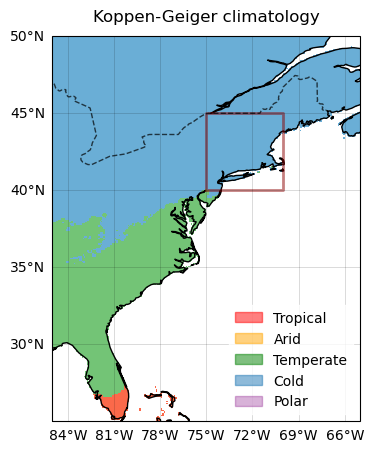

In [47]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

# add box around area of interest
xn, xx, yn, yx = [-75,-70,40,45]
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

plt.legend(handles = [matplotlib.patches.Patch(color = "red", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "orange", label = "Arid", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "green", label = "Temperate", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "tab:blue", label = "Cold", alpha = 0.5),
                      matplotlib.patches.Patch(color = "purple", label = "Polar", alpha = 0.3)], 
           edgecolor = "w", loc = "lower right")

plt.title("Koppen-Geiger climatology")

## **Maps of the event**

### **Overview of daily precip**

In [4]:
pr = wrap_lon(xr.open_dataset("data/era5_tp_daily_na_extended_-85--65E_25-50N_su.nc").tp)

In [78]:
pr.sel(time = slice("2023-07-07", "2023-07-10")).plot(col = "time", cmap = "YlGnBu", vmax = 100,
                                                      cbar_kwargs = {"location" : "top", "fraction" : 0.1, "pad" : 0.2},
                                                      subplot_kws = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(wspace = 0.005, top = 0.7)

zz = plt.gcf().axes

for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

In [78]:
zz

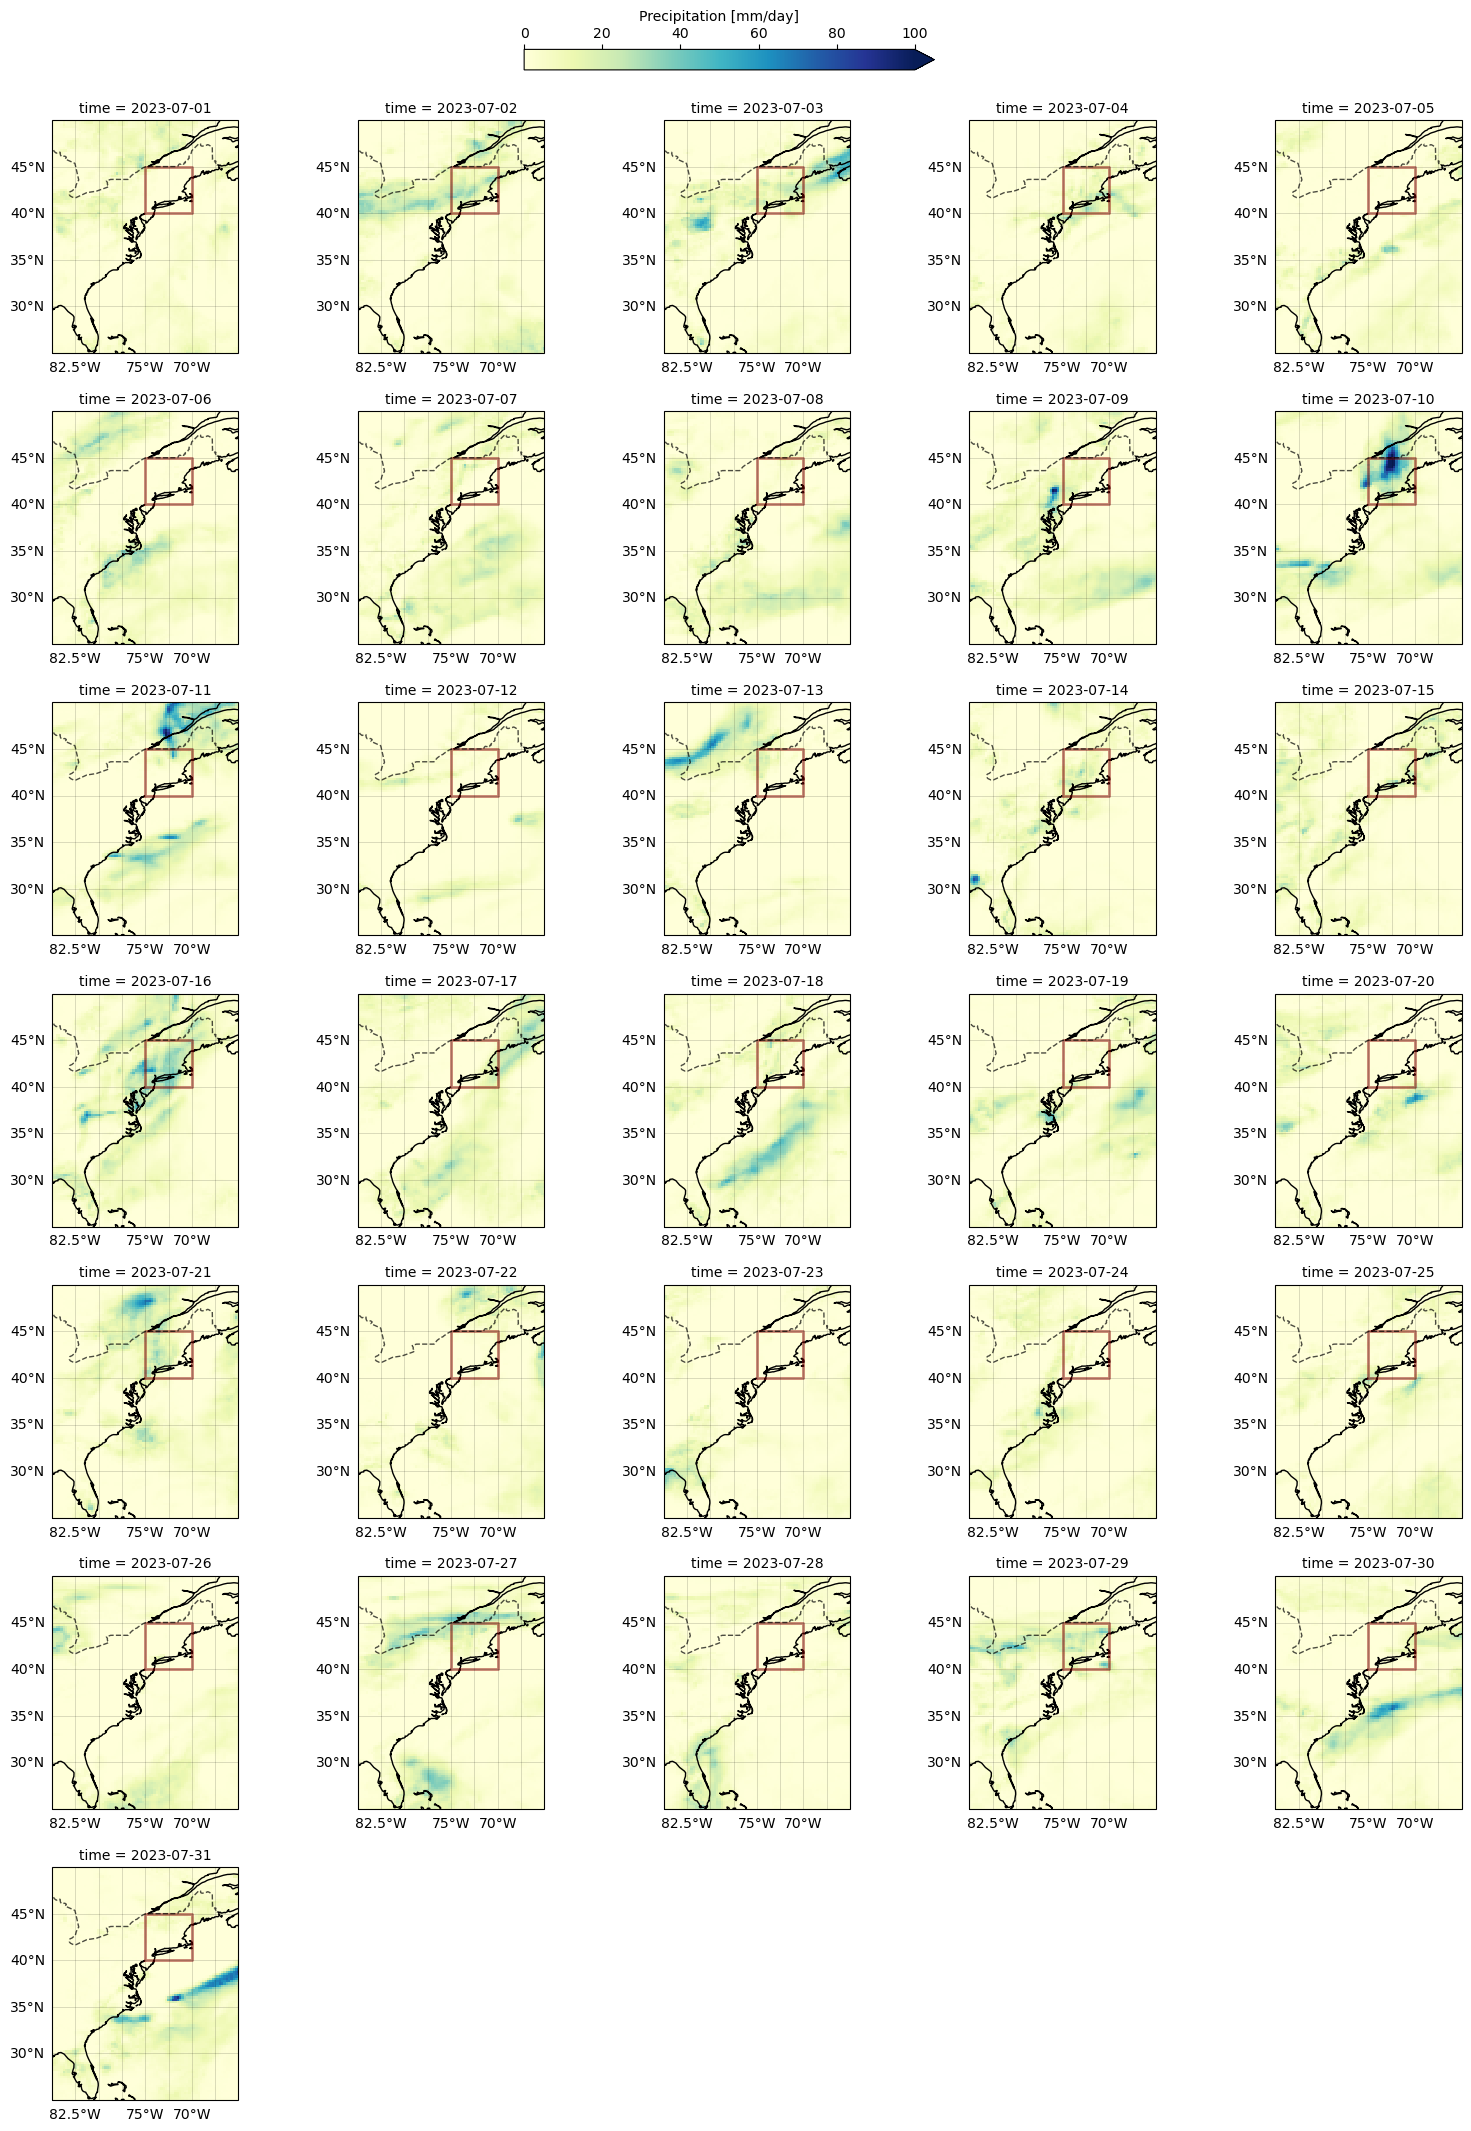

In [158]:
pr.sel(time = "2023-07").plot(col = "time", col_wrap = 5, cmap = "YlGnBu", 
                              vmax = 100, cbar_kwargs = {"location" : "top", "fraction" : 0.01, "pad" : 0.02},
                              subplot_kws = {"projection" : cartopy.crs.PlateCarree(), "extent" : (lons.start, lons.stop, lats.start, lats.stop)}
                             )
plt.subplots_adjust(hspace = 0.25, top = 0.95)


### **Closer look at the affected area**

River basin shapefiles: https://www.hydrosheds.org/products/hydrobasins

In [36]:
# define a smaller region to look at
new_lons = slice(-77.5,-67.5); new_lats = slice(40,47.5)

# identify affected states
sf_states = gpd.read_file("sf_USA/").clip([new_lons.start, new_lons.stop, new_lats.start, new_lats.stop])
sf_states = sf_states.loc[[n in ["Pennsylvania", "Connecticut", "Vermont", "New Jersey", "Maryland", "New York"] for n in sf_states.NAME]]
sf_states = sf_states.loc[[n in ["Connecticut"] for n in sf_states.NAME]]

# load river basin shapefile
sf_hybas03 = gpd.read_file("sf_hybas03-NA/").clip([new_lons.start, new_lons.stop, new_lats.start, new_lats.stop])
sf_hybas04 = gpd.read_file("sf_hybas04-NA/").clip([new_lons.start, new_lons.stop, new_lats.start, new_lats.stop])

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use

In [11]:
# get lat & lon of places mentioned in the trigger
affected_sites = ["Hudson Valley", "Rockland County", "Westchester County"]
px = pd.DataFrame([get_latlon(s) for s in affected_sites])

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


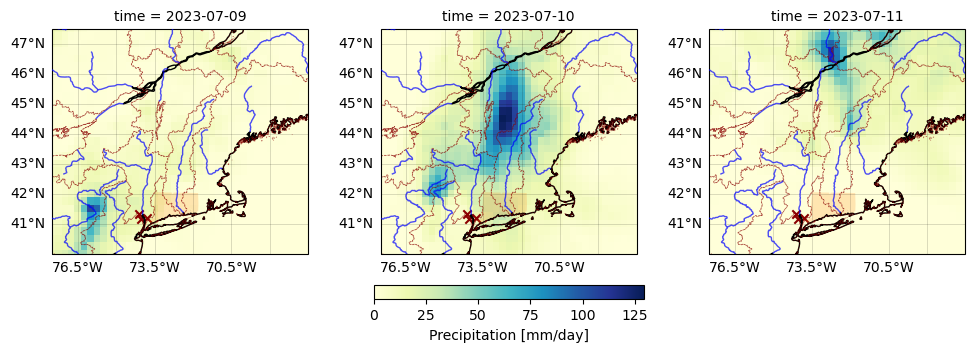

In [38]:
pr.sel(time = slice("2023-07-09", "2023-07-11"), lon = new_lons, lat = new_lats).plot(cmap = "YlGnBu", col = "time",
                                                                                      subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                                                                     "extent" : (new_lons.start, new_lons.stop, new_lats.start, new_lats.stop)},
                                                                                      cbar_kwargs = {"location" : "bottom", "fraction" : 0.05})
plt.subplots_adjust(wspace = 0.05, bottom = 0.2)

for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
    # ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    
    # add points where impacts were reported
    ax.scatter(px.lon, px.lat, marker = "x", color = "darkred")
    
    # add rivers
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", lw = 1, alpha = 0.7, ls = "-", zorder = 99)

    # shade states where impacts were reported
    sf_states.plot(ax = ax, lw = 1, alpha = 0.2, color = "tab:orange")
    
    # add river basins
    sf_hybas04.boundary.plot(ax = ax, lw = 0.5, ls = "--", color = "darkred", alpha = 0.5)
    
    # # add a box around the region
    # ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

### **Maps of anomalies**

In [44]:
# get JJA climatology as reference
pr_clim = pr.sel(time = slice("1980", "2010")).groupby("time.season")["JJA"].mean("time")
pr_anom = pr - pr_clim

In [49]:
# just JJA anomalies
pr_jja = pr.sel(time = slice("1980", "2010")).groupby("time.season")["JJA"]
pr_jja_anom = pr_jja - pr_jja.mean("time")

In [46]:
# JJAS climatology
pr_jjas = pr.sel(time = [m in [6,7,8,9] for m in pr.time.dt.month]).mean()

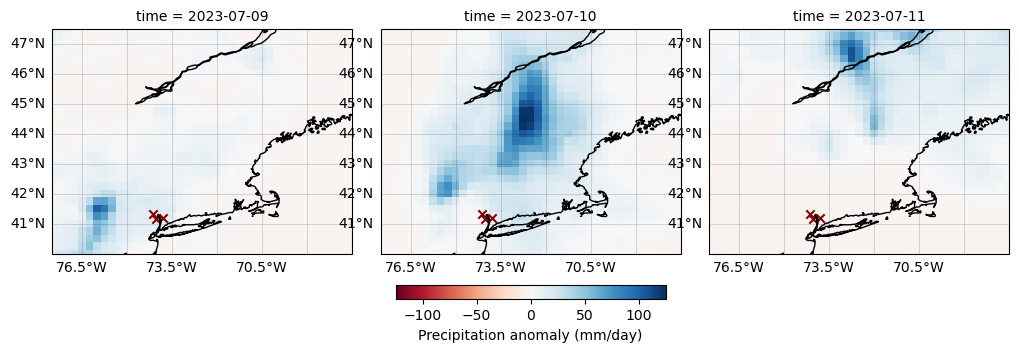

In [50]:
pr_anom.sel(time = slice("2023-07-09", "2023-07-11"), lon = new_lons, lat = new_lats).plot(cmap = "RdBu", col = "time",
                                                                                      subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                                                                     "extent" : (new_lons.start, new_lons.stop, new_lats.start, new_lats.stop)},
                                                                                      cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "label" : "Precipitation anomaly (mm/day)"})
plt.subplots_adjust(wspace = 0.05, bottom = 0.2)

for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
    # ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    
    # add points where impacts were reported
    ax.scatter(px.lon, px.lat, marker = "x", color = "darkred")
    
#     # add rivers
#     ax.add_feature(cartopy.feature.RIVERS, color = "blue", lw = 1, alpha = 0.7, ls = "-", zorder = 99)

#    # shade states where impacts were reported
#    sf_states.plot(ax = ax, lw = 1, alpha = 0.2, color = "tab:orange")
    
#     # add river basins
#     sf_hybas04.boundary.plot(ax = ax, lw = 0.5, ls = "--", color = "darkred", alpha = 0.5)
    
#     # add a box around the region
#     # ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

### **Maps of accumulations**

In [52]:
prn = pr.rolling(time = 3, center = False).sum()

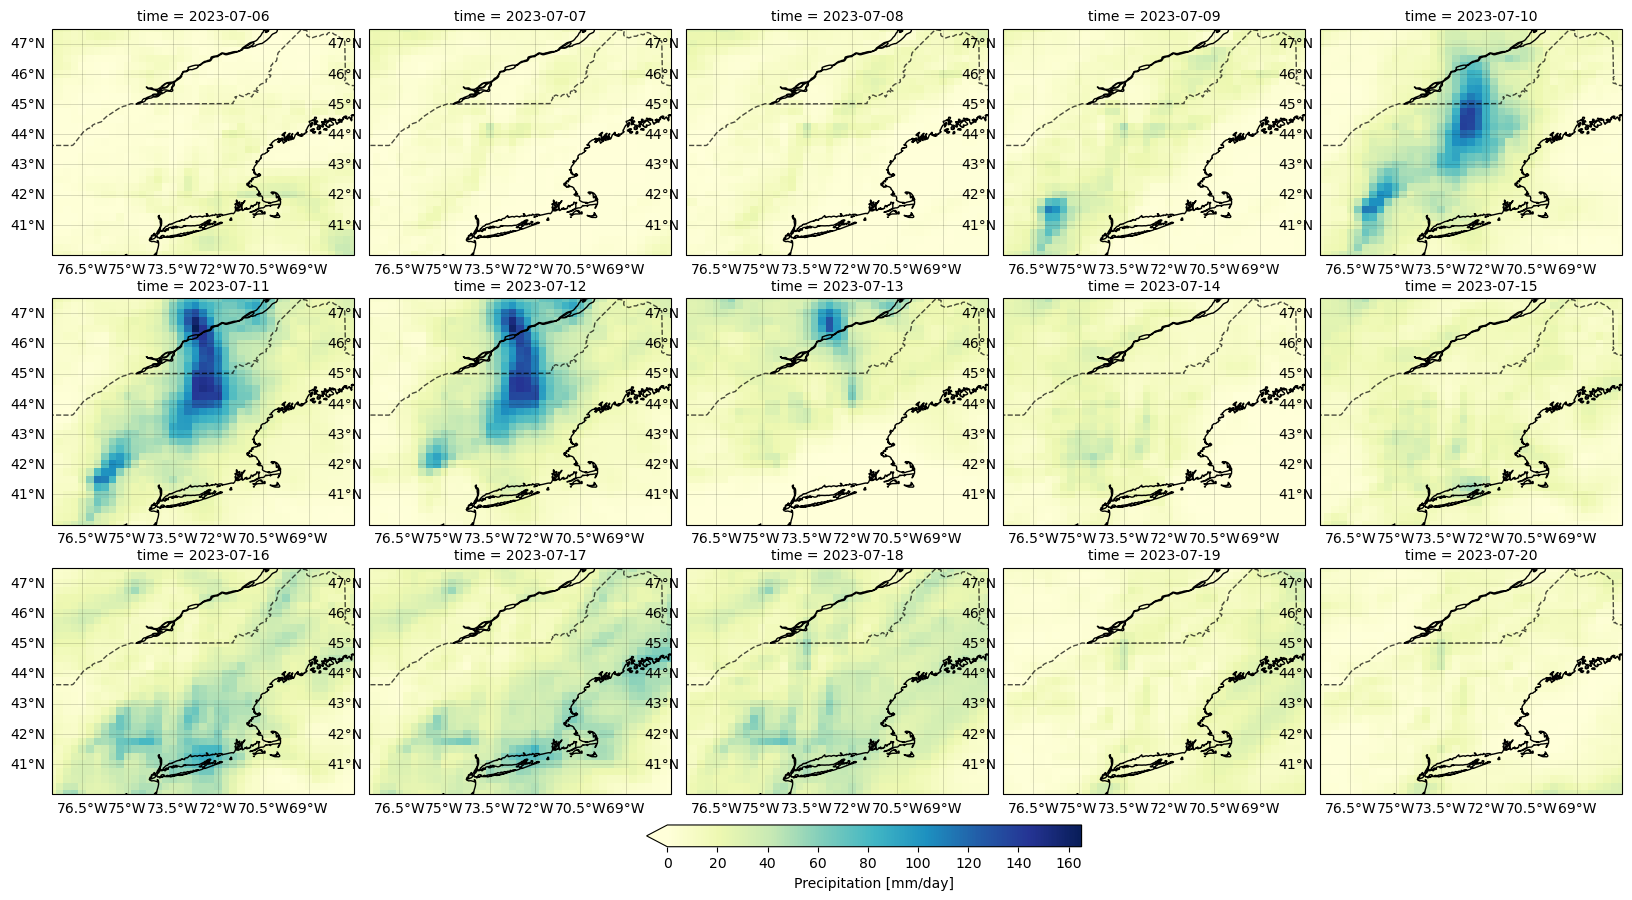

In [53]:
prn.sel(time = slice("2023-07-06", "2023-07-20")).plot(cmap = "YlGnBu", col = "time", col_wrap = 5, vmin = 0,
                                                       subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                                      "extent" : (new_lons.start, new_lons.stop, new_lats.start, new_lats.stop)},
                                                       cbar_kwargs = {"location" : "bottom", "fraction" : 0.025, "pad" : 0.05})
plt.subplots_adjust(wspace = 0.05, bottom = 0.075)

for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

## **Create shapefile for study region**

### **Select a region by merging polygons**

<GeoAxesSubplot: title={'center': 'time = 2023-07-10'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

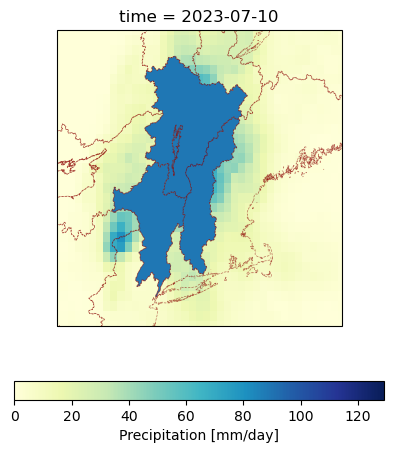

In [74]:
fig = pr.sel(time = "2023-07-10", lon = new_lons, lat = new_lats).plot(cmap = "YlGnBu", subplot_kws = {"projection" : cartopy.crs.PlateCarree(), "extent" : (new_lons.start, new_lons.stop, new_lats.start, new_lats.stop)},
                                                                 cbar_kwargs = {"location" : "bottom", "fraction" : 0.05})
ax = fig.axes
sf_hybas04.boundary.plot(ax = ax, lw = 0.5, ls = "--", color = "darkred", alpha = 0.5)

# add shapefiles until happy with outline
sf_hybas04.loc[[151, 149, 134, 131]].plot(ax = ax)

In [78]:
sf = sf_hybas04.loc[[151, 149, 134, 131]].dissolve()

# sometimes necessary to remove islands & other sub-polygons - although not needed in this case
sf = sf.explode(index_parts = False)
sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]
sf.to_file("sf_studyregion")

/tmp/ipykernel_19947/4265701556.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]


<AxesSubplot: >

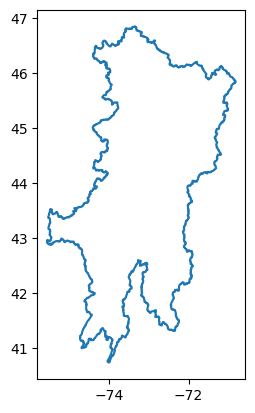

In [70]:
sf.boundary.plot()

### **Convert shapefile to points for Climate Explorer**

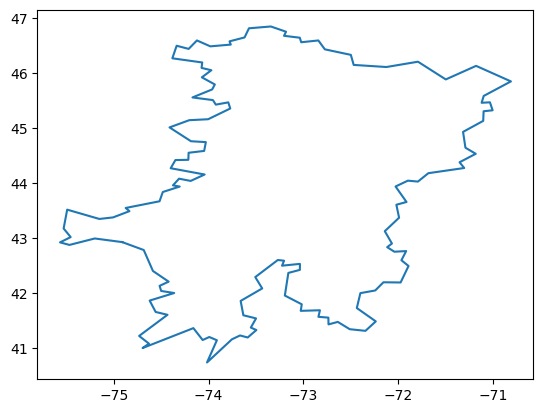

In [68]:
# extract points from polygon
# sf_px = sf["geometry"].apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))    # export exact shapefile
sf_px = sf.simplify(0.05).apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"})) # smooth the edges of the shapefile first
plt.plot(sf_px.x, sf_px.y)

In [374]:
sf_px.to_csv("study-region-coordinates.txt", sep = " ", index = False)

## **Extract time series using shapefile**

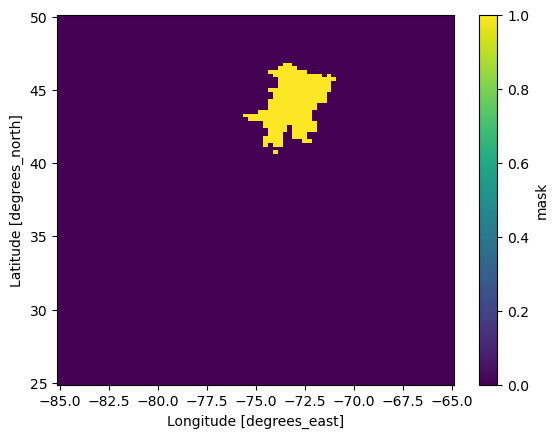

In [82]:
# make binary regionmask from shapefile & data coordinates
rm = regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat).squeeze(drop = True)
rm.plot()

In [85]:
# use regionmask to extract time series of average over study region
pr_ts = pr.where(rm == 1).mean(["lat", "lon"])
pr_ts.to_netcdf("daily-ts_pr.nc")

### **Plot distribution of time series**

In [86]:
# define axis labels for DOY plotting
days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 1]
labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 1]

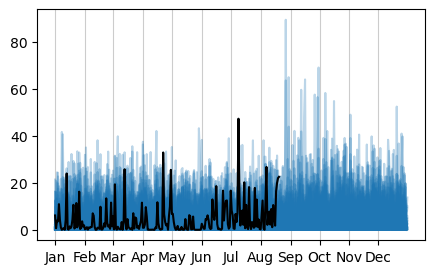

In [99]:
# How unusual is this year's distribution?

fig, ax = plt.subplots(ncols = 1, figsize = (5,3), dpi = 100)

# loop over each year & plot the annual time series
for y in np.unique(pr_ts.time.dt.year):
    pr_y = pr_ts.sel(time = str(y))
    ax.plot(pr_y.time.dt.dayofyear, pr_y, color = "tab:blue", alpha = 0.3)
    
ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
ax.grid(axis = "x", color = "k", alpha = 0.2)

# add this year in a different colour
pr_y = pr_ts.sel(time = "2023")
ax.plot(pr_y.time.dt.dayofyear, pr_y, color = "k")

(0.0, 200.0)

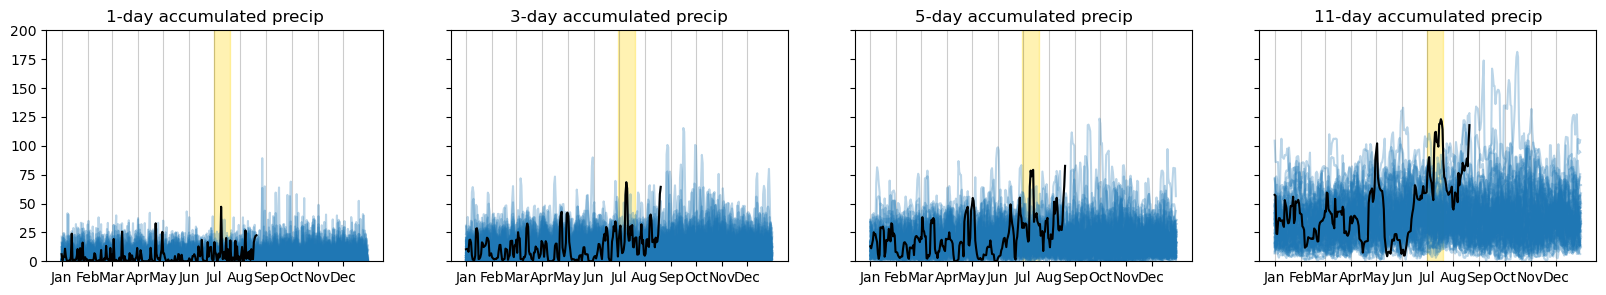

In [112]:
# Compare a few accumulations

fig, axs = plt.subplots(ncols = 4, figsize = (20,3), dpi = 100, sharey = True)

# loop over each year & plot the annual time series
for i in range(4):
    ax = axs[i]
    ndays = [1,3,5,11][i]
    
    pr_nday = pr_ts.rolling(time = ndays, center = False).sum()
    
    for y in np.unique(pr_ts.time.dt.year):
        pr_y = pr_nday.sel(time = str(y))
        ax.plot(pr_y.time.dt.dayofyear, pr_y, color = "tab:blue", alpha = 0.3)
        
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    ax.grid(axis = "x", color = "k", alpha = 0.2)
    
    ax.set_title(str(ndays)+"-day accumulated precip")
    
    # add a rectangle shading the time period of interest (get & set ylims to avoid resizing the plot)
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((pr_ts.sel(time = "2023-07-01").time.dt.dayofyear.values,-5), 20, 300, color = "gold", alpha = 0.3)) # 20-day period starting from July 1st
    ax.set_ylim(ylim)
    
    # add this year in a different colour
    pr_y = pr_nday.sel(time = "2023")
    ax.plot(pr_y.time.dt.dayofyear, pr_y, color = "k")
    
ax.set_ylim(0,200)

### **Create time series for climate explorer**

In [120]:
# compute time series - annual maximum of JJA precip
ndays = 1

nday_precip = pr_ts.rolling(time = ndays).sum()
nday_jja = nday_precip.groupby("time.season")["JJA"]
nday_jja_max = nday_jja.resample(time = "AS-JAN").max()

cx_ts = pr_ts.rolling(time = ndays).sum().groupby("time.season")["JJA"].resample(time = "AS-JAN").max()

In [125]:
# specify filename
csv_fnm = "ts/ny-flooding_era5_rx1day.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

In [123]:
# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 rx1day - New York flooding 2023, c.barnes22@imperial.ac.uk"
str2 = "# rx1day [mm/day] annual maximum of 1-day accumulated precipitation over NE USA at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year rx1day"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
cx_ts.assign_coords(time = cx_ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

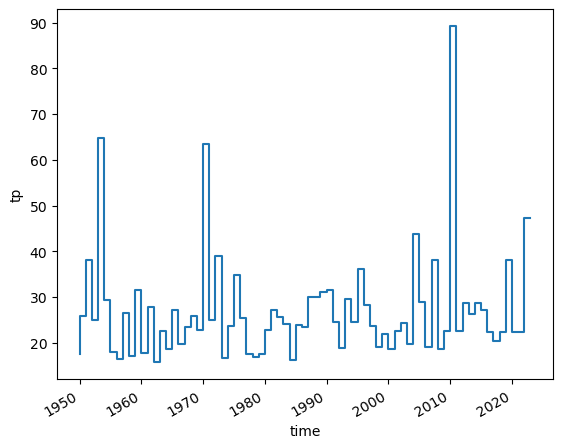

In [407]:
cx_ts.plot(drawstyle = "steps")

### **Event map**

In [134]:
# identify the day on which the highest precip occurred
ndays = 1
pr_ts.rolling(time = ndays).sum().groupby("time.season")["JJA"].sel(time = "2023").idxmax()

<xarray.DataArray 'time' ()>
array('2023-07-10T00:00:00.000000000', dtype='datetime64[ns]')

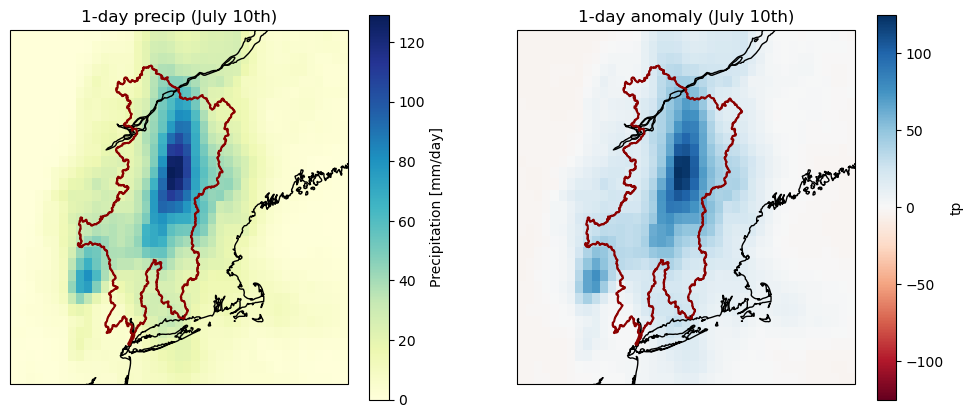

In [135]:
pr_nday = pr.rolling(time = ndays).sum().sel(lon = new_lons, lat = new_lats)
pr_nday = pr_nday.where(pr_nday > 0, 0)    # sometimes get tiny negative values due to numerical instabilities - this removes them

fig, axs = plt.subplots(ncols = 2, figsize = (12,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

pr_nday.sel(time = "2023-07-10").plot(ax = axs[0], cmap = "YlGnBu")
axs[0].set_title(str(ndays)+"-day precip (July 10th)")

(pr_nday.sel(time = "2023-07-10") - pr_nday.sel(time = slice("1980", "2010")).groupby("time.season")["JJA"].mean("time")).plot(ax = axs[1], cmap = "RdBu")
axs[1].set_title(str(ndays)+"-day anomaly (July 10th)")

for ax in axs:
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")

## **Synoptic meteorology**

In [137]:
ds = wrap_lon(xr.open_dataset("data/era5_uv-psl_2023-07.nc")).resample(time = "D").mean().sel(time = slice("2023-07-08", "2023-07-11"), longitude = new_lons, latitude = new_lats)
ds["msl"] = ds.msl / 100
# ds = ds.sel(longitude = slice(-160,-154), latitude = slice(23,18))
# ds["msl"] = ds.msl - ds.msl.mean("time")

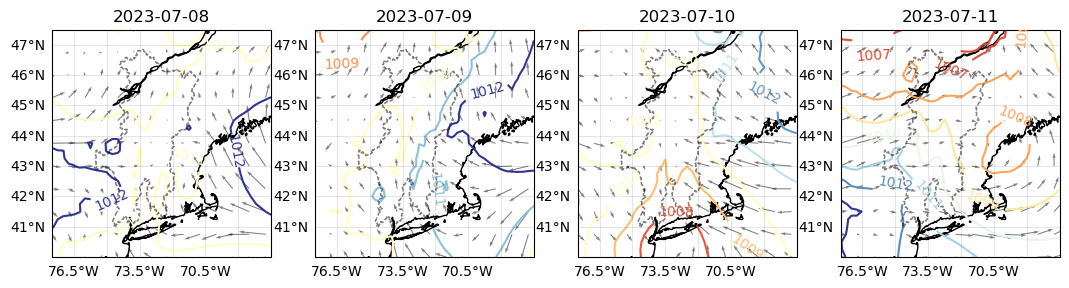

In [155]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (13,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

for i in range(4):
    
    ax = fig.axes[i]
    
    ds_i = ds.isel(time = i)
    
    cs = ax.contour(ds.longitude, ds.latitude, ds_i.msl, cmap = "RdYlBu", levels = range(int(np.floor(ds_i.msl.min())), int(np.ceil(ds_i.msl.max()))))
    ax.clabel(cs)
    
    st=3
    ax.quiver(ds.longitude[::st], ds.latitude[::st], ds_i.u10[::st,::st], ds_i.v10[::st,::st], alpha = 0.5)
    # ax.quiver(ds.longitude, ds.latitude, ds_i.u10, ds_i.v10, alpha = 0.5)
    
    ax.set_title(ds_i.time.dt.date.values)
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])